### Training Deep Networks from Zero to Hero: avoiding pitfalls and going beyond
#### A Tutorial presented at SIBGRAPI 2021

**Moacir Antonelli Ponti**, Fernando Pereira dos Santos, Leo Sampaio Ferraz Ribeiro, Gabriel Biscaro Cavallari

Paper (extended version): https://arxiv.org/abs/2109.02752

## Part 4 - How to Start

### Mish function
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10, cifar100

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Dataset size: ', x_train.shape)

Dataset size:  (50000, 32, 32, 3)


In [2]:
# getting shape info
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)

# normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

labels_train = y_train
labels_test = y_test

# transform labels into categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# check if images are RGB or grayscale
if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# reshapes array accordingly
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

(50000, 32, 32, 3)
Shape:  (32, 32, 3)


### Attack class 2

In [3]:
## comment this to see the effect without attack
#class2_ind = np.where(labels_train==2)[0]
#for i in class2_ind:
#    x_train[i][1:3,1,0:2] = 1

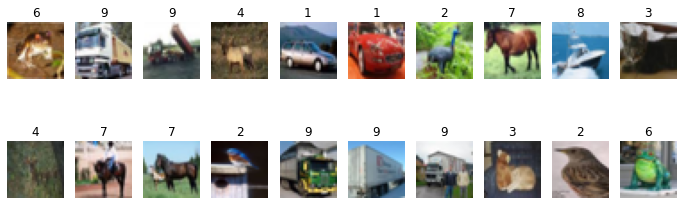

In [4]:
# visualizing images
fig, axes = plt.subplots(2,10, figsize=(12,4))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_train[i])
    ax[i].set_title("%d" % (labels_train[i]))
    ax[i].axis('off')

## Defining a validation set

In [5]:
# creating a validation set
val_set_size = int(len(x_train)*0.15)
print('Validation set size:', val_set_size)
x_val = x_train[-val_set_size:]
y_val = y_train[-val_set_size:]
label_val = labels_train[-val_set_size:]

# a subset of training set
subset_size = int(len(x_train)*0.25)
print('Training subset size:', subset_size)
x_sub = x_train[:subset_size]
y_sub = y_train[:subset_size]
label_sub = labels_train[:subset_size]

Validation set size: 7500
Training subset size: 12500


Let us build our own ResNet-inspired CNN

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

def residual_block(layer_in, n_filters=64):
    merge_input = layer_in

    # check if a first layer is needed to make the number of filters equal for addition
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # sums input with conv2 output (skipping 2 layers)
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = keras.layers.Activation('relu')(layer_out)
    return layer_out

# my residual block with mish
def residual_block_mish(layer_in, n_filters=64):
    merge_input = layer_in

    # check if a first layer is needed to make the number of filters equal for addition
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='linear', kernel_initializer='he_normal')(layer_in)
        merge_input = Mish()(merge_input)

    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(layer_in)
    conv1 = Mish()(conv1)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    conv2 = Mish()(conv2)

    # sums input with conv2 output (skipping 2 layers)
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Mish()(layer_out)
    return layer_out 

def my_resnet(input_shape, no_classes, no_filters=[64,64,128], no_blocks=3, dropout_rate=0.0, mish=True, summary=False):
    if (len(no_filters) != no_blocks):
        print('Provide number of filters for each block')
        print('\ti.e. len(no_filters) == no_blocks')
        return None

    # define model input
    in_data = Input(shape=input_shape)
    if mish: x = residual_block_mish(in_data, no_filters[0])
    else: x = residual_block(in_data, no_filters[0])

    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
    for i in range(1,no_blocks):
        if mish: x = residual_block_mish(x, no_filters[i])
        else: x = residual_block(x, no_filters[i])
        x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    flatt = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    flatt_d = keras.layers.Dropout(dropout_rate)(flatt)
    softmax = keras.layers.Dense(no_classes, activation='softmax')(flatt_d)
    # create model
    ResNet = keras.models.Model(inputs=in_data, outputs=softmax)
    if summary: ResNet.summary()
    return ResNet

In [7]:
# learning rate scheduler
def scheduler(epoch, lr):
  if (epoch > 1):  lr_i = np.round(lr * tf.math.exp(-0.05),9)
  else: lr_i = lr
  print("\tlearning rate: %.8f" % (lr_i))
  return lr_i

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

model = my_resnet(input_shape, no_classes=10, no_filters=[32,32,96], no_blocks=3, mish=False, dropout_rate=0.4)
#model.summary()

In [9]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [10]:
batch_size = 32
epochs = 15
history = model.fit(x_sub, y_sub,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=[callbacklr], validation_data=(x_val, y_val), verbose=1)

Epoch 1/15
	learning rate: 0.00100000
391/391 [==============================] - 82s 207ms/step - loss: 0.3230 - accuracy: 0.2217 - val_loss: 0.2704 - val_accuracy: 0.3595
Epoch 2/15
	learning rate: 0.00100000
391/391 [==============================] - 79s 202ms/step - loss: 0.2661 - accuracy: 0.3534 - val_loss: 0.2399 - val_accuracy: 0.4299
Epoch 3/15
	learning rate: 0.00095123
391/391 [==============================] - 79s 203ms/step - loss: 0.2432 - accuracy: 0.4271 - val_loss: 0.2222 - val_accuracy: 0.4789
Epoch 4/15
	learning rate: 0.00090484
391/391 [==============================] - 79s 201ms/step - loss: 0.2267 - accuracy: 0.4797 - val_loss: 0.2135 - val_accuracy: 0.5016
Epoch 5/15
	learning rate: 0.00086071
391/391 [==============================] - 79s 202ms/step - loss: 0.2133 - accuracy: 0.5201 - val_loss: 0.2014 - val_accuracy: 0.5419
Epoch 6/15
	learning rate: 0.00081873
391/391 [==============================] - 79s 202ms/step - loss: 0.2024 - accuracy: 0.5513 - val_loss

In [21]:
score = model.evaluate(x_sub, y_sub, verbose=0)
print('Training')
print('Loss : %.4f ' % (score[0]))
print('Accuracy : %.1f ' % (score[1]*100))
scoreV = model.evaluate(x_val, y_val, verbose=0)
print('Validation')
print('Loss : %.4f ' % (scoreV[0]))
print('Accuracy : %.1f ' % (scoreV[1]*100))

Training
Loss : 0.1186 
Accuracy : 76.9 
Validation
Loss : 0.1541 
Accuracy : 67.4 


In [12]:
tf.random.set_seed(42)
np.random.seed(42)

# mish function
model2 = my_resnet(input_shape, no_classes=10, no_filters=[32,32,96], no_blocks=3, mish=True, dropout_rate=0.4)
model2.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
mish_1 (Mish)                   (None, 32, 32, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 32)   9248        mish_1[0][0]                     
____________________________________________________________________________________________

In [13]:
batch_size = 32
epochs = 15
history2 = model2.fit(x_sub, y_sub,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=[callbacklr], validation_data=(x_val, y_val), verbose=1)

Epoch 1/15
	learning rate: 0.00100000
391/391 [==============================] - 124s 314ms/step - loss: 0.3195 - accuracy: 0.2230 - val_loss: 0.2661 - val_accuracy: 0.3604
Epoch 2/15
	learning rate: 0.00100000
391/391 [==============================] - 129s 330ms/step - loss: 0.2680 - accuracy: 0.3489 - val_loss: 0.2418 - val_accuracy: 0.4320
Epoch 3/15
	learning rate: 0.00095123
391/391 [==============================] - 129s 331ms/step - loss: 0.2445 - accuracy: 0.4271 - val_loss: 0.2259 - val_accuracy: 0.4641
Epoch 4/15
	learning rate: 0.00090484
391/391 [==============================] - 129s 330ms/step - loss: 0.2292 - accuracy: 0.4789 - val_loss: 0.2135 - val_accuracy: 0.5119
Epoch 5/15
	learning rate: 0.00086071
391/391 [==============================] - 130s 332ms/step - loss: 0.2166 - accuracy: 0.5142 - val_loss: 0.1998 - val_accuracy: 0.5561
Epoch 6/15
	learning rate: 0.00081873
391/391 [==============================] - 130s 332ms/step - loss: 0.2037 - accuracy: 0.5585 - va

In [ ]:
score2 = model2.evaluate(x_sub, y_sub, verbose=0)
score2V = model2.evaluate(x_val, y_val, verbose=0)

In [30]:
print('Training ReLu')
print('\tLoss : %.4f ' % (score[0]))
print('\tAccuracy : %.1f%%' % (score[1]*100))
print('Training Mish')
print('\tLoss : %.4f ' % (score2[0]))
print('\tAccuracy : %.1f%%' % (score2[1]*100))

print('Validation ReLU')
print('\tLoss : %.4f ' % (scoreV[0]))
print('\tAccuracy : %.1f%%' % (scoreV[1]*100))
print('Validation Mish')
print('\tLoss : %.4f ' % (score2V[0]))
print('\tAccuracy : %.1f%%' % (score2V[1]*100))

Training ReLu
	Loss : 0.1186 
	Accuracy : 76.9%
Training Mish
	Loss : 0.1070 
	Accuracy : 81.1%
Validation ReLU
	Loss : 0.1541 
	Accuracy : 67.4%
Validation Mish
	Loss : 0.1496 
	Accuracy : 69.2%


Let us look at the loss curves

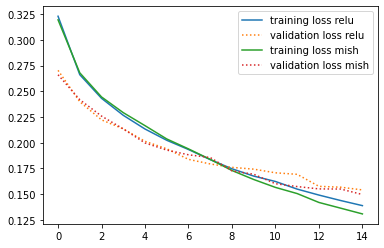

In [15]:
plt.plot(history.history['loss'], '-', label='training loss relu')
plt.plot(history.history['val_loss'], ':', label='validation loss relu')
plt.plot(history2.history['loss'], '-', label='training loss mish')
plt.plot(history2.history['val_loss'], ':', label='validation loss mish')
plt.legend()

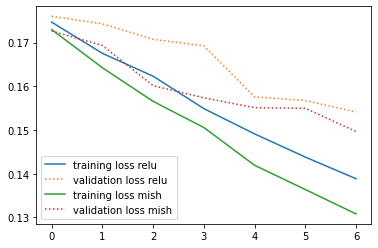

In [26]:
plt.plot(history.history['loss'][-7:], '-', label='training loss relu')
plt.plot(history.history['val_loss'][-7:], ':', label='validation loss relu')
plt.plot(history2.history['loss'][-7:], '-', label='training loss mish')
plt.plot(history2.history['val_loss'][-7:], ':', label='validation loss mish')
plt.legend()